[![Kaggle](https://kaggle.com/static/images/open-in-kaggle.svg)](https://kaggle.com/kernels/welcome?src=https://github.com/pixeltable/pixeltable/blob/release/docs/notebooks/integrations/working-with-together.ipynb)&nbsp;&nbsp;
[![Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/pixeltable/pixeltable/blob/release/docs/notebooks/integrations/working-with-together.ipynb)

# Working with Together AI in Pixeltable

### Prerequisites
- A Together AI account with an API key (https://api.together.ai/settings/api-keys)

### Important Notes

- Together.ai usage may incur costs based on your Together.ai plan.
- Be mindful of sensitive data and consider security measures when integrating with external services.

First you'll need to install required libraries and enter your Together API key.

In [ ]:
%pip install -qU pixeltable together

In [ ]:
import os
import getpass

if 'TOGETHER_API_KEY' not in os.environ:
    os.environ['TOGETHER_API_KEY'] = getpass.getpass('Together API Key: ')

Now let's create a Pixeltable directory to hold the tables for our demo.

In [1]:
import pixeltable as pxt

pxt.drop_dir('together_demo', force=True)  # Ensure a clean slate for the demo
pxt.create_dir('together_demo')

Connected to Pixeltable database at: postgresql://postgres:@/pixeltable?host=/Users/asiegel/.pixeltable/pgdata
Created directory `together_demo`.


## Completions

Now we create a table in Pixeltable, with three columns:

- a column to hold the inputs (prompts);
- a computed column that calls the Together AI completions API and stores the JSON response;
- another computed column that extracts the completion from the response JSON.

In [2]:
from pixeltable.functions.together import completions

t = pxt.create_table('together_demo.completions', {'input': pxt.String})

# We'll use the lightweight Mistral-7B-Instruct model for this demo, but you can use
# any model supported by Together AI.

t.add_computed_column(output=completions(
    prompt=t.input,
    model='mistralai/Mistral-7B-Instruct-v0.3',
    max_tokens=300
))
t.add_computed_column(response=t.output.choices[0].text)

Created table `completions`.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


Here's the schema of the new table:

In [3]:
t

Column Name,Type,Computed With
input,string,
output,json,"completions(input, max_tokens=300, model='mistralai/Mistral-7B-Instruct-v0.3')"
response,json,output.choices[0].text


Now we can insert some queries into our new table.

In [4]:
# Start a conversation
t.insert([
    {'input': 'On November 19, 1863, '},
    {'input': 'Beethoven was the first '}
])

Computing cells: 100%|████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/ cells]
Inserting rows into `completions`: 2 rows [00:00, 256.77 rows/s]
Computing cells: 100%|████████████████████████████████████████████| 6/6 [00:09<00:00,  1.66s/ cells]
Inserted 2 rows with 0 errors.


UpdateStatus(num_rows=2, num_computed_values=6, num_excs=0, updated_cols=[], cols_with_excs=[])

Querying the results:

In [5]:
t.select(t.input, t.response).head()

input,response
"On November 19, 1863,","150,000 Union soldiers gathered at Gettysburg, Pennsylvania, for a speech by President Abraham Lincoln. The speech, now known as the Gettysburg Address, was only 272 words long, but it has become one of the most famous speeches in American history. In the speech, Lincoln redefined the purpose of the Civil War. He said that the war was not just about preserving the Union, but also about establishing a government ""of the people, by the people, for the people."" Lincoln also emphasized the impo ...... he full text of the Gettysburg Address: Four score and seven years ago our fathers brought forth on this continent a new nation, conceived in Liberty, and dedicated to the proposition that all men are created equal. Now we are engaged in a great civil war, testing whether that nation, or any nation so conceived and so dedicated, can long endure. We are met on a great battle-field of that war. We have come to dedicate a portion of that field, as a final resting place for those who here gave"
Beethoven was the first,"> to write a symphony in C minor, and it was the first to be performed in the new Berlin Philharmonic Hall. The first symphony in C minor was Mozart's Symphony No. 40 in C minor, K. 550, which was composed in 1788. Beethoven's Symphony No. 3 in C minor, Op. 55, commonly known as the Eroica, was composed in 1803-1804 and was the first symphony to be performed in the new Berlin Philharmonic Hall, but it was not the first symphony in C minor. > Beethoven's Symphony No. 5 in C minor, Op. 67, is one of the most famous and recognizable pieces of classical music. Yes, that is correct. Beethoven's Symphony No. 5 in C minor, Op. 67, is one of the most famous and recognizable pieces of classical music. It was composed in 1808 and is often considered a masterpiece of the symphonic form. The opening motif of the symphony, consisting of four notes (short-short-short-long), is one of the most famous and recognizable melodies in Western music."


## Chat Completions

In [6]:
from pixeltable.functions.together import chat_completions

chat_t = pxt.create_table('together_demo.chat', {'input': pxt.String})

# The chat-completions API expects JSON-formatted input:
messages = [{'role': 'user', 'content': chat_t.input}]

# This example shows how additional parameters from the Together API can be used in
# Pixeltable to customize the model behavior.
chat_t.add_computed_column(output=chat_completions(
    messages=messages,
    model='mistralai/Mixtral-8x7B-Instruct-v0.1',
    max_tokens=300,
    stop=['\n'],
    temperature=0.7,
    top_p=0.9,
    top_k=40,
    repetition_penalty=1.1,
    logprobs=1,
    echo=True
))
chat_t.add_computed_column(response=chat_t.output.choices[0].message.content)

Created table `chat`.
Added 0 column values with 0 errors.
Added 0 column values with 0 errors.


In [7]:
# Start a conversation
chat_t.insert([
    {'input': 'How many species of felids have been classified?'},
    {'input': 'Can you make me a coffee?'}
])
chat_t.select(chat_t.input, chat_t.response).head()

Computing cells: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.16 cells/s]
Inserting rows into `chat`: 2 rows [00:00, 106.92 rows/s]
Computing cells: 100%|████████████████████████████████████████████| 6/6 [00:01<00:00,  3.11 cells/s]
Inserted 2 rows with 0 errors.


input,response
How many species of felids have been classified?,"There are 41 species of felids, or members of the family Felidae, that have been classified. This includes well-known cats like lions, tigers, and domestic cats, as well as lesser-known species such as the fishing cat and the flat-headed cat. This number can vary slightly depending on the source and the taxonomic scheme used to classify the animals."
Can you make me a coffee?,"I'm sorry for any confusion, but I'm unable to physically make you a coffee as I'm just a text-based program running on computers around the world. However, I can certainly help you find a recipe or provide instructions on how to make one if you'd like! Would you be interested in that?"


## Embeddings

In [8]:
from pixeltable.functions.together import embeddings

emb_t = pxt.create_table('together_demo.embeddings', {'input': pxt.String})
emb_t.add_computed_column(embed=embeddings(
    input=emb_t.input,
    model='togethercomputer/m2-bert-80M-8k-retrieval'
))

Created table `embeddings`.
Added 0 column values with 0 errors.


In [9]:
emb_t.insert(input='Together AI provides a variety of embeddings models.')

Computing cells:  50%|██████████████████████                      | 1/2 [00:00<00:00,  3.27 cells/s]
Inserting rows into `embeddings`: 1 rows [00:00, 233.71 rows/s]
Computing cells: 100%|████████████████████████████████████████████| 2/2 [00:00<00:00,  6.30 cells/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

In [10]:
emb_t.head()

input,embed
Together AI provides a variety of embeddings models.,[ 0.016 -0.21 0.201 0.153 -0.339 0.164 ... -0.049 0.003 -0.157 0.178 -0.063 -0.168]


## Image Generations

In [11]:
from pixeltable.functions.together import image_generations

image_t = pxt.create_table('together_demo.images', {'input': pxt.String, 'negative_prompt': pxt.String})
image_t.add_computed_column(img=image_generations(
    image_t.input,
    model='stabilityai/stable-diffusion-xl-base-1.0'
))

Created table `images`.
Added 0 column values with 0 errors.


In [12]:
# Start generating Images
image_t.insert([
  {'input': 'A friendly dinosaur playing tennis in a cornfield'}
])

Computing cells:   0%|                                                    | 0/2 [00:00<?, ? cells/s]
Inserting rows into `images`: 1 rows [00:00, 577.65 rows/s]
Computing cells: 100%|███████████████████████████████████████████| 2/2 [00:00<00:00, 535.50 cells/s]
Inserted 1 row with 0 errors.


UpdateStatus(num_rows=1, num_computed_values=2, num_excs=0, updated_cols=[], cols_with_excs=[])

In [13]:
image_t

Column Name,Type,Computed With
input,string,
negative_prompt,string,
img,image,"image_generations(input, model='stabilityai/stable-diffusion-xl-base-1.0')"


input,negative_prompt,img
A friendly dinosaur playing tennis in a cornfield,None,

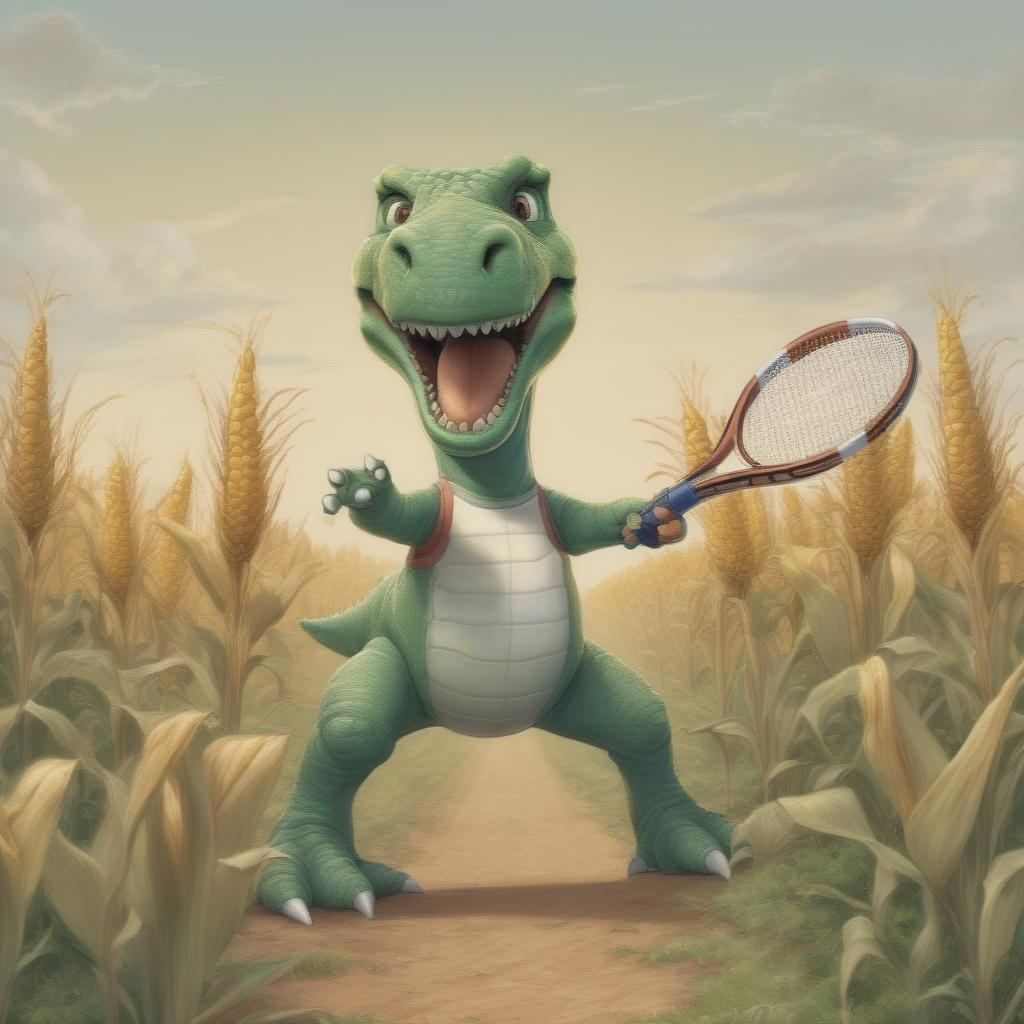

In [14]:
image_t.head()

### Learn More

To learn more about advanced techniques like RAG operations in Pixeltable, check out the [RAG Operations in Pixeltable](https://pixeltable.readme.io/docs/rag-operations-in-pixeltable) tutorial.

You can also look at how to work with images in Pixeltable: [Working with Images](https://pixeltable.readme.io/docs/working-with-images).

If you have any questions, don't hesitate to reach out.